# Loop and TAD calling

This page shows how to identify chromatin loops and TADs from an example multiplexed FISH data. The data is from [Takei et al, 2021](https://www.nature.com/articles/s41586-020-03126-2), where the authors performed both genome-scale chromatin tracing at a resolution of 1Mb and local chromatin tracing at a resolution of 25Kb.

Here only the 25Kb resolution subset from replicate-1 is used. This subset can be downloaded from [4DN data portal](https://data.4dnucleome.org) with ID [4DNFIHF3JCBY](https://data.4dnucleome.org/files-processed/4DNFIHF3JCBY/). Briefly, for each chromosome, a region is selected and imaged at 60 loci, and the 1D genomic distance between two consecutive loci is 25Kb.

In [1]:
import snapfish2 as sf

## Data loading

The data from 4DN are in [FOF-CT_core](https://fish-omics-format.readthedocs.io/en/latest/core.html#core) format. SnapFISH2 handles the data through `sf.tl.MulFish`:

In [2]:
mfr = sf.tl.MulFish("4DNFIHF3JCBY.csv")
mfr["chr1"]  # Indexing by chromosome

,Trace_ID,Chrom_Start,Spot_ID,X,Y,Z,Chrom,Chrom_End,Cell_ID,Extra_Cell_ROI_ID,locus
0,0_1_1_0,135600000,NaN,NaN,NaN,NaN,chr1,135625000,0_1,NaN,0
1,0_1_1_0,135625000,705144.0,176.998,15.132,2.821,chr1,135650000,0_1,0.0,1
2,0_1_1_0,135650000,705145.0,176.953,15.056,2.771,chr1,135675000,0_1,0.0,2
3,0_1_1_0,135675000,NaN,NaN,NaN,NaN,chr1,135700000,0_1,NaN,3
4,0_1_1_0,135700000,705147.0,176.965,15.131,2.591,chr1,135725000,0_1,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...
25435,4_31_1_1,136975000,1020675.0,145.014,40.347,3.270,chr1,137000000,4_31,4.0,55
25436,4_31_1_1,137000000,1020677.0,145.187,40.304,3.186,chr1,137025000,4_31,4.0,56
25437,4_31_1_1,137025000,NaN,NaN,NaN,NaN,chr1,137050000,4_31,NaN,57
25438,4_31_1_1,137050000,NaN,NaN,NaN,NaN,chr1,137075000,4_31,NaN,58


Note now `X`, `Y`, and `Z` are the image pixel positions. To convert them to the actual physical position in nm:

In [3]:
mfr.data["X"] = mfr.data["X"] * 103
mfr.data["Y"] = mfr.data["Y"] * 103
mfr.data["Z"] = mfr.data["Z"] * 250

The data for a single chromosome can be converted to a pairwise distance array using `sf.tl.ChromArray`. The array is stored as a `zarr` file and loaded into memory by `dask`. Calculations on the array can be done by calling `dask` methods on the `arr` attribute.

In [4]:
import dask.array as da
carr = sf.tl.ChromArray(mfr["chr6"])
carr.load_write("tmp_carr")
# Median pairwise distance using dask
pdist_arr = da.sqrt(da.sum(da.square(carr.arr), axis=1))
med_dist = da.nanmedian(pdist_arr, axis=0).compute()

Once the calculation is done, the `zarr` file can be removed:

In [5]:
carr.close()

In this case, the result of the calculation is the median pairwise distance matrix, which can be visualized as a heatmap using `sf.pl.pairwise_heatmap`.

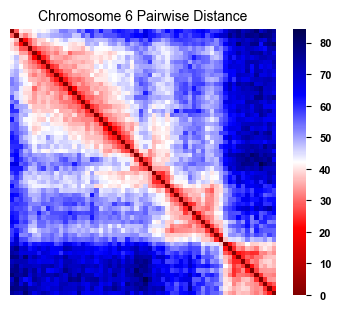

In [6]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(4, 3))
sf.pl.pairwise_heatmap(med_dist, ax=ax, title="Chromosome 6 Pairwise Distance")

:::{seealso}
Read more about indexing and data storage in [Data Loading and Storage](load_storage.ipynb).
:::

## Loop calling

`sf.loop.LoopCaller` is the base class to call chromatin loops. The required input are the chromatin tracing data and the path of a directory to store the intermediate `zarr` files. To call chromatin loops from a single chromosome, use the `loops_from_single_chr` method and specify the test method. 

In [7]:
lc = sf.loop.LoopCaller(mfr.data, "tmp")
res = lc.loops_from_single_chr("chr6", sf.loop.AxisWiseF)
res.keys()

dict_keys(['axis_stat', 'axis_pval', 'stat', 'pval', 'fdr', 'candidate', 'label', 'summit'])

The result is a dictionary with values being $p$ by $p$ matrices, where $p$ equals the number of locus of the chromosome. The result can be visualized as heatmaps through `SnapFISH2`'s heatmap wrapper `sf.pl.pairwise_heatmap`.

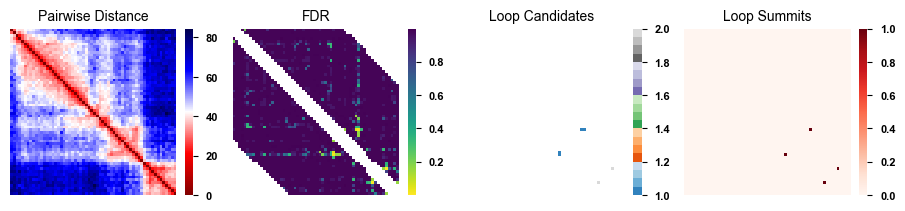

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(9, 2))
sf.pl.pairwise_heatmap(med_dist, title=f"Pairwise Distance", ax=axes[0])
sf.pl.pairwise_heatmap(res["fdr"], title="FDR", cmap="viridis_r", ax=axes[1])
sf.pl.pairwise_heatmap(res["label"], title="Loop Candidates", cmap="tab20c", ax=axes[2])
sf.pl.pairwise_heatmap(res["summit"], title="Loop Summits", cmap="Reds", ax=axes[3])

The `to_bedpe` method converts the result to a dataframe, with each row being a locus pair.

In [9]:
lc.to_bedpe(res, "chr6")

,c1,s1,e1,c2,s2,e2,stat,pval,fdr,candidate,label,summit
0,chr6,49375000,49400000,chr6,49400000,49425000,NaN,NaN,NaN,False,NaN,False
1,chr6,49375000,49400000,chr6,49450000,49475000,NaN,NaN,NaN,False,NaN,False
2,chr6,49375000,49400000,chr6,49475000,49500000,0.815600,0.282219,0.989540,False,NaN,False
3,chr6,49375000,49400000,chr6,49500000,49525000,202.431279,0.001572,0.199698,False,NaN,False
4,chr6,49375000,49400000,chr6,49525000,49550000,0.005510,0.498246,0.989540,False,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1765,chr6,50825000,50850000,chr6,50875000,50900000,NaN,NaN,NaN,False,NaN,False
1766,chr6,50825000,50850000,chr6,50900000,50925000,NaN,NaN,NaN,False,NaN,False
1767,chr6,50850000,50875000,chr6,50875000,50900000,NaN,NaN,NaN,False,NaN,False
1768,chr6,50850000,50875000,chr6,50900000,50925000,NaN,NaN,NaN,False,NaN,False


Use `loops_from_all_chr` to call chromatin loops from all chromosomes at once and output the dataframe.

In [10]:
lc.loops_from_all_chr(sf.loop.AxisWiseF)

/opt/miniconda3/lib/python3.12/site-packages/dask/_task_spec.py:744: RuntimeWarning: All-NaN slice encountered
  return self.func(*new_argspec, **kwargs)


,c1,s1,e1,c2,s2,e2,stat,pval,fdr,candidate,label,summit
0,chr1,135600000,135625000,chr1,135625000,135650000,NaN,NaN,NaN,False,NaN,False
1,chr1,135600000,135625000,chr1,135650000,135675000,NaN,NaN,NaN,False,NaN,False
2,chr1,135600000,135625000,chr1,135675000,135700000,NaN,NaN,NaN,False,NaN,False
3,chr1,135600000,135625000,chr1,135700000,135725000,-0.301177,0.593117,0.946108,False,NaN,False
4,chr1,135600000,135625000,chr1,135725000,135750000,-0.287788,0.589195,0.946108,False,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
35395,chrX,76925457,76950457,chrX,76975457,77000457,NaN,NaN,NaN,False,NaN,False
35396,chrX,76925457,76950457,chrX,77000457,77025457,NaN,NaN,NaN,False,NaN,False
35397,chrX,76950457,76975457,chrX,76975457,77000457,NaN,NaN,NaN,False,NaN,False
35398,chrX,76950457,76975457,chrX,77000457,77025457,NaN,NaN,NaN,False,NaN,False


## TAD calling

The base class for TAD calling is `sf.domain.TADCaller`. The `by_pval` method returns a length $p$ data frame, where each row is a locus and contains the testing results for whether it is a TAD boundary. The `to_bedpe` method outputs a dataframe, where each row contains the two boundaries of a TAD identified. The `tree` argument indicates whether to return hierarchical relations of TADs.

In [11]:
tad = sf.domain.TADCaller(mfr["chr6"], 1e5, "tmp")
df = tad.by_pval(0.1)
bedpe = tad.to_bedpe(df, "stat", tree=False)

The TAD calling result can be visualized by first plotting the median pairwise distance then adding the TAD boundaries through `sf.pl.plot_TAD_boundary`.

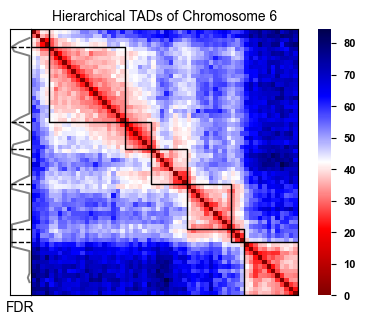

In [12]:
fig, ax = plt.subplots(figsize=(3.6, 3))
sf.pl.pairwise_heatmap(
    med_dist, ax=ax, cbar=True,
    title=f"Hierarchical TADs of Chromosome 6",
)
caxs = sf.pl.plot_TAD_boundary(
    df, bedpe,
    cols=["fdr"],
    tad_colors=["k"],
    line_colors=["grey"],
    line_names=["FDR"],
    linewidth=1, alpha=1, ax=ax, rotation=0
)

To call TADs from all chromosomes instead of just chromosome 6, replace `sf.domain.TADCaller(mfr["chr6"], 1e5, "tmp")` by `sf.domain.TADCaller(mfr.data, 1e5, "tmp")` and rerun the `to_pval` and `to_bedpe` methods.

After the analysis is done, the directory to store `zarr` files can be removed:

In [13]:
import shutil
shutil.rmtree("tmp")